#Libraries

In [ ]:
import numpy as np
import os
from pathlib import Path
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import DenseNet121
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import shutil

#Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Augmentation

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Instantiate the ImageDataGenerator class
datagen = ImageDataGenerator(
    rotation_range=40,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    zca_whitening=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Specify the input and output directories
input_directory = '/content/drive/MyDrive/Major_project/Datasets/datasets/Curated X-Ray Dataset'
output_directory = '/content/drive/MyDrive/augmented'

# Loop over the data in batches and save the augmented images to different class directories
for class_folder in os.listdir(input_directory):
    class_path = os.path.join(input_directory, class_folder)
    if os.path.isdir(class_path):
        output_class_directory = os.path.join(output_directory, class_folder)
        os.makedirs(output_class_directory, exist_ok=True)

        i = 0
        for batch in datagen.flow_from_directory(class_path, batch_size=64, target_size=(224, 224),
                                                 save_to_dir=output_class_directory, save_prefix='', save_format='jpg'):
            i += 1
            if i > 51:
                break



/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1451: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 0 images belonging to 0 classes.


KeyboardInterrupt: 

#folder spliter

In [ ]:
pip install split-folders

In [ ]:
import splitfolders
input_folder = '/content/drive/MyDrive/Major_project/Datasets/datasets/Curated X-Ray Dataset'
splitfolders.ratio(input_folder,output='/content/drive/MyDrive/dataset(1)',
                   seed=42, ratio=(.7,.3,.0),
                   group_prefix=None)

Copying files: 9208 files [10:25, 14.71 files/s]


#counter

In [ ]:
train_path = '/content/drive/MyDrive//dataset(1)/train'

image_files = []


for class_folder in os.listdir(train_path):
    class_path = os.path.join(train_path, class_folder)
    i=0
    if os.path.isdir(class_path):
      for filename in os.listdir(class_path):
        i+=1
        file_path = os.path.join(class_path,filename)
        image_files.append(file_path)
      print(class_path,i)
print(image_files)


/content/drive/MyDrive//dataset(1)/train/COVID-19 896
/content/drive/MyDrive//dataset(1)/train/Normal 2289
/content/drive/MyDrive//dataset(1)/train/Pneumonia-Bacterial 2100
/content/drive/MyDrive//dataset(1)/train/Pneumonia-Viral 1159
['/content/drive/MyDrive//dataset(1)/train/COVID-19/COVID-19 (1018).jpg', '/content/drive/MyDrive//dataset(1)/train/COVID-19/COVID-19 (102).jpg', '/content/drive/MyDrive//dataset(1)/train/COVID-19/COVID-19 (1008).jpg', '/content/drive/MyDrive//dataset(1)/train/COVID-19/COVID-19 (1012).jpg', '/content/drive/MyDrive//dataset(1)/train/COVID-19/COVID-19 (1014).jpg', '/content/drive/MyDrive//dataset(1)/train/COVID-19/COVID-19 (1).jpg', '/content/drive/MyDrive//dataset(1)/train/COVID-19/COVID-19 (1015).jpg', '/content/drive/MyDrive//dataset(1)/train/COVID-19/COVID-19 (1011).jpg', '/content/drive/MyDrive//dataset(1)/train/COVID-19/COVID-19 (1004).jpg', '/content/drive/MyDrive//dataset(1)/train/COVID-19/COVID-19 (1016).jpg', '/content/drive/MyDrive//dataset(1)/tr

#Resnet

In [ ]:
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=True)

  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=10, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True

  # Compile ResNet-50 model
  resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()

  return resnet_model

#Vgg

In [ ]:
def get_vgg_model():
    pre_trained_model = VGG16(weights="imagenet")
    extract_model = Model(inputs=pre_trained_model.inputs, outputs = pre_trained_model.get_layer("fc1").output)
    return extract_model

#Denset

In [ ]:
def get_densenet_model():
  base_model = DenseNet121(weights='imagenet', include_top=False)
  model = Model(inputs=base_model.input, outputs=base_model.output)
  return model

#image feature vector extractor

In [ ]:
def getFeatureVector(model, img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  feature_vector = model.predict(img.reshape(1, 224, 224, 3))
  return feature_vector.flatten()

In [ ]:
#To change the folder from where the image features have to extracted go to counter section
#above and change the directory

def getFeatureDataFrame(model):
  df = pd.DataFrame(columns=['file', 'features'])
  df['file'] = image_files

  df['features'] = df.apply(lambda row: getFeatureVector(model, row['file']), axis=1)

  #for index, row in df.iterrows():
    #row['features'] = getFeatureVector(model,row['file'])
    #print(row['file'])
    #print(row['features'])
    #print(index)

  print("All files added.")
  return df

#Different Similarity measures

In [ ]:
# Get cosine similarity between feature vectors A and B using cosine similarity
def getCosineSimilarity(A, B):
  cos_similarity = np.dot(A,B.T) / (np.linalg.norm(A)*np.linalg.norm(B)) # Get cosine similarity
  return cos_similarity

In [ ]:
# Get euclidean distance between feature vectors A and B using euclidean distance
def getEuclideanDistance(A, B):
  euclidean_distance = np.linalg.norm(A - B)
  return euclidean_distance


#Preparing resnet model for extraction

In [ ]:
res_model = getResNet50Model(lastFourTrainable=False)
feature_model_res = Model(inputs=res_model.input, outputs=res_model.get_layer('new_fc').output)

102967424/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

#extracting features with resnet

In [ ]:
df = getFeatureDataFrame(feature_model_res)

Streaming output truncated to the last 5000 lines.
1094
1/1 [==============================] - 0s 21ms/step
/content/drive/MyDrive/dataset(1)/val/Normal/Normal (3102).jpg
1095
1/1 [==============================] - 0s 28ms/step
/content/drive/MyDrive/dataset(1)/val/Normal/Normal (721).jpg
1096
1/1 [==============================] - 0s 36ms/step
/content/drive/MyDrive/dataset(1)/val/Normal/Normal (1486).jpg
1097
1/1 [==============================] - 0s 23ms/step
/content/drive/MyDrive/dataset(1)/val/Normal/Normal (795).jpg
1098
1/1 [==============================] - 0s 24ms/step
/content/drive/MyDrive/dataset(1)/val/Normal/Normal (1789).jpg
1099
1/1 [==============================] - 0s 23ms/step
/content/drive/MyDrive/dataset(1)/val/Normal/Normal (2789).jpg
1100
1/1 [==============================] - 0s 22ms/step
/content/drive/MyDrive/dataset(1)/val/Normal/Normal (521).jpg
1101
1/1 [==============================] - 0s 26ms/step
/content/drive/MyDrive/dataset(1)/val/Normal/Normal (20

#Copy the Resnet features to a file

In [ ]:
df.to_pickle('/content/drive/MyDrive/train_features_res.pickle')
df.head()

#Extracting Features with Vgg

In [ ]:
vgg_model= get_vgg_model()
df = getFeatureDataFrame(vgg_model)
df.head()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 1s/step
All files added.


,file,features
0,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 4.767228, 5.6182594, 0.0, 0.0, 0.0,..."
1,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 4.5176263, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 3.5552764, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.87..."
4,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.35907608, 5.988329, 0.0, 0.0, 0.0..."


#Copy the vgg features to a file

In [ ]:
df.to_pickle('/content/drive/MyDrive/train_features_vgg.pickle')
df.head()

,file,features
0,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 4.767228, 5.6182594, 0.0, 0.0, 0.0,..."
1,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 4.5176263, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 3.5552764, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.87..."
4,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.35907608, 5.988329, 0.0, 0.0, 0.0..."


#extracting features with densenet

In [ ]:
densenet_model= get_densenet_model()
df = getFeatureDataFrame(densenet_model)
df.head()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step
All files added.


,file,features
0,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013854082, 0..."
1,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025659539, 0..."
3,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016417302, 0...."
4,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0031987496, 0.0, 0.0, 0.0, 0..."


#copy the densenet features to file

In [ ]:
df.to_pickle('/content/drive/MyDrive/train_features_densenet.pickle')
df.head()

,file,features
0,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013854082, 0..."
1,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025659539, 0..."
3,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016417302, 0...."
4,/content/drive/MyDrive//dataset(1)/train/COVID...,"[0.0, 0.0, 0.0, 0.0031987496, 0.0, 0.0, 0.0, 0..."


#Function for getting similar images

In [ ]:
def getSimilarImages(img_file, features_df, model, model_name):
  img_features = getFeatureVector(model, img_file)
  features_df['similarity'] = features_df.apply(lambda row: getCosineSimilarity(img_features,np.asarray(row['features'])), axis=1)
  sorted_df = features_df.sort_values(by='similarity', ascending=False)
  sorted_df = sorted_df[:10]
  print(sorted_df)
  return sorted_df

#Getting Similar Images

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/train_features_vgg.pickle')

#For resnet
#res_model = Model(inputs=res_model.input, outputs=res_model.get_layer('new_fc').output)

#For vgg
vgg_model= get_vgg_model()

#For densenet
#densenet_model= get_densenet_model()

similar_images = getSimilarImages('/content/drive/MyDrive/dataset(1)/val/COVID-19/COVID-19 (1260).jpg',df,vgg_model,'vgg')

1/1 [==============================] - 1s 757ms/step
                                                  file  \
230  /content/drive/MyDrive//dataset(1)/train/COVID...   
398  /content/drive/MyDrive//dataset(1)/train/COVID...   
152  /content/drive/MyDrive//dataset(1)/train/COVID...   
189  /content/drive/MyDrive//dataset(1)/train/COVID...   
182  /content/drive/MyDrive//dataset(1)/train/COVID...   
785  /content/drive/MyDrive//dataset(1)/train/COVID...   
438  /content/drive/MyDrive//dataset(1)/train/COVID...   
254  /content/drive/MyDrive//dataset(1)/train/COVID...   
343  /content/drive/MyDrive//dataset(1)/train/COVID...   
828  /content/drive/MyDrive//dataset(1)/train/COVID...   

                                              features  similarity  
230  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.40...    0.899123  
398  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.15...    0.854774  
152  [0.0, 0.0, 3.1016226, 0.0, 0.0, 0.0, 0.0, 3.87...    0.848881  
189  [0.0, 0.0, 2.7489362, 0.0, 

#Plotting the Similar images

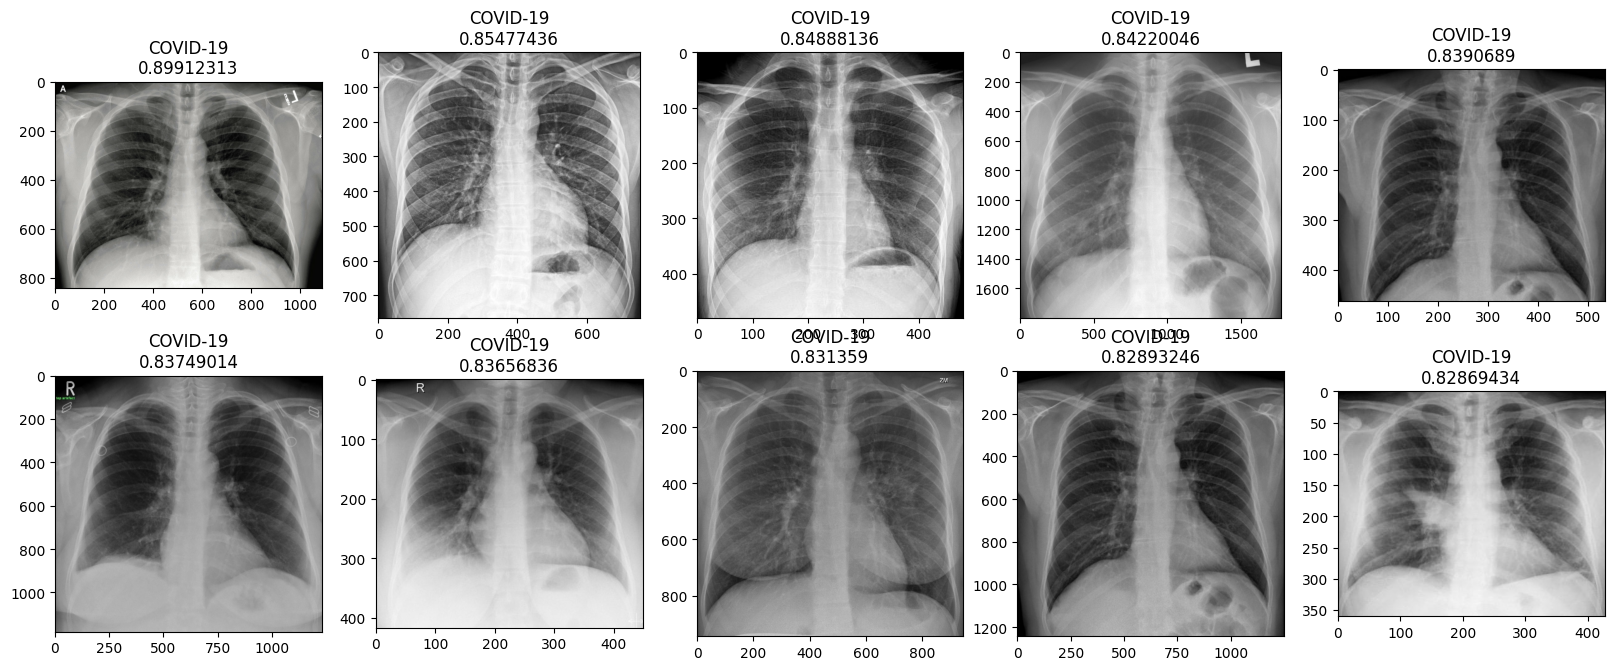

In [ ]:
fig = plt.figure(figsize=(20,20))
for i in range(10):
  img = cv2.imread(similar_images.iloc[i,0])
  y = fig.add_subplot(5,5, i+1)
  y.imshow(img, cmap='gray')
  y.set_title(similar_images.iloc[i,0].split("/"or" ")[-2]+"\n"+str(similar_images.iloc[i,2]))
plt.show()

#Precision@recall100

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.neighbors import NearestNeighbors
import os

# Loading Resnet model
res_model = getResNet50Model(lastFourTrainable=False)
model = Model(inputs=res_model.input, outputs=res_model.get_layer('new_fc').output)

# Extract features for all images in the dataset
features_list = []
image_paths = []

i=0
for root, dirs, files in os.walk('/content/drive/MyDrive//dataset(1)/train'):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            features = model.predict(img.reshape(1, 224, 224, 3))
            features = features.flatten()
            features_list.append(features)
            image_paths.append(img_path)
            i+=1
            print(i)
print("done")

"""
            img_path = os.path.join(root, file)
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            features = model.predict(x)
            features = features.flatten()
            features_list.append(features)
            image_paths.append(img_path)
"""

# Convert features list to numpy array
features_array = np.array(features_list)

# Fit a nearest neighbors model using the features
neighbors_model = NearestNeighbors(n_neighbors=2289, algorithm='auto', metric='cosine')
neighbors_model.fit(features_array)

# Define a function to retrieve images based on a query image and calculate precision
def retrieve_images(query_image_path):
    # Extract features for the query image
    img = cv2.imread(query_image_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    query_features = model.predict(img.reshape(1, 224, 224, 3))
    query_features = query_features.flatten()

    """
    img = image.load_img(query_image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    query_features = model.predict(x)
    query_features = query_features.flatten()
    """

    # Find nearest neighbors for the query image
    distances, indices = neighbors_model.kneighbors(query_features.reshape(1, -1))

    # Get the class of the query image
    query_class = os.path.basename(os.path.dirname(query_image_path))

    # Retrieve images of the same class
    same_class_indices = [i for i in range(len(image_paths)) if os.path.basename(os.path.dirname(image_paths[i])) == query_class]

    # Get the last index of a retrieved image of the same class as the query image
    last_retrieved_index = -1
    for i in range(len(indices[0])):
        if indices[0][i] in same_class_indices:
            last_retrieved_index = i

    # Calculate precision based on retrieved images
    precision = (last_retrieved_index + 1) / 2289

    # Return the precision and image path
    return precision, query_image_path

# Define the path to the test directory
test_dir_path = '/content/drive/MyDrive//dataset(1)/val/Pneumonia-Bacterial'

# Retrieve similar images and precision for each test image
results = []
i=0
for root, dirs, files in os.walk(test_dir_path):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            test_image_path = os.path.join(root, file)
            precision, image_path = retrieve_images(test_image_path)
            results.append((image_path, precision))
            print(i)
            i+=1

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['Image Path', 'Precision'])

# Save the DataFrame to a CSV file
df.to_csv("/content/drive/MyDrive/Major_project/results/DENSENET_precion@recall100_pb.csv",index='false')

Streaming output truncated to the last 5000 lines.
4845
1/1 [==============================] - 0s 216ms/step
4846
1/1 [==============================] - 0s 203ms/step
4847
1/1 [==============================] - 0s 203ms/step
4848
1/1 [==============================] - 0s 225ms/step
4849
1/1 [==============================] - 0s 200ms/step
4850
1/1 [==============================] - 0s 210ms/step
4851
1/1 [==============================] - 0s 220ms/step
4852
1/1 [==============================] - 0s 206ms/step
4853
1/1 [==============================] - 0s 197ms/step
4854
1/1 [==============================] - 0s 218ms/step
4855
1/1 [==============================] - 0s 332ms/step
4856
1/1 [==============================] - 0s 343ms/step
4857
1/1 [==============================] - 0s 335ms/step
4858
1/1 [==============================] - 0s 332ms/step
4859
1/1 [==============================] - 0s 342ms/step
4860
1/1 [==============================] - 0s 332ms/step
4861
1/1 [===========

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.neighbors import NearestNeighbors
import os
# Load VGG16 model
model = ResNet50(weights='imagenet', include_top=True)

# Extract features for all images in the dataset
features_list = []
image_paths = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Major_project/data2 (2)/Train'):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            img_path = os.path.join(root, file)
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            features = model.predict(x)
            features = features.flatten()
            features_list.append(features)
            image_paths.append(img_path)

# Convert features list to numpy array
features_array = np.array(features_list)

# Fit a nearest neighbors model using the features
neighbors_model = NearestNeighbors(n_neighbors=15 ,algorithm='auto', metric='cosine')
neighbors_model.fit(features_array)

# Define a function to retrieve images based on a query image and calculate precision
def retrieve_images(query_image_path):
    # Extract features for the query image
    img = image.load_img(query_image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    query_features = model.predict(x)
    query_features = query_features.flatten()

    # Find nearest neighbors for the query image
    distances, indices = neighbors_model.kneighbors(query_features.reshape(1, -1))

    # Get the class of the query image
    query_class = os.path.basename(os.path.dirname(query_image_path))

    # Retrieve images of the same class
    same_class_indices = [i for i in range(len(image_paths)) if os.path.basename(os.path.dirname(image_paths[i])) == query_class]

    # Count the number of relevant images retrieved (same class as the query image)
    relevant_images = len(set(indices[0]).intersection(set(same_class_indices)))

    # Calculate precision based on retrieved images
    precision = relevant_images / 15

    # Return the precision and image path
    return precision, query_image_path

# Define the path to the test directory
test_dir_path = '/content/drive/MyDrive/Major_project/data2 (2)/Test'

# Retrieve similar images and precision for each test image
results = []
for root, dirs, files in os.walk(test_dir_path):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            test_image_path = os.path.join(root, file)
            precision, image_path = retrieve_images(test_image_path)
            results.append((image_path, precision))

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['Image Path', 'Precision'])

# Save the DataFrame to a CSV file
df.to_csv('top15_resnet.csv', index=False)

1/1 [==============================] - 4s 4s/step
[0.        0.        0.        ... 3.731648  1.9364586 0.       ]
